[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Trusted-AI/AIF360/blob/master/examples/sklearn/demo_bias_explanation.ipynb)

# Getting Started

In [1]:
#Install AIF360
# !pip install 'aif360'

The code relies on FairXplainer package [1], which can be installed by `pip install fairxplainer`. Checkout the [Github](https://github.com/ReAILe/bias-explainer) repository for details on installation.

In [2]:
#Install FairXplainer
!pip install 'fairxplainer'
!pip show fairxplainer # a package required to explain bias

Name: fairxplainer
Version: 0.3.0
Summary: A Python package for explaining bias in machine learning models
Home-page: https://github.com/ReAILe/bias-explainer
Author: Bishwamittra Ghosh
Author-email: bishwamittra.ghosh@gmail.com
License: MIT
Location: /Users/bishwamittraghosh/mambaforge-pypy3/envs/python37/lib/python3.7/site-packages
Requires: 
Required-by: 


In [3]:
%matplotlib inline
import sys
sys.path.append('../..')
from aif360.sklearn.datasets import fetch_adult, fetch_compas, fetch_german
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np

pip install 'aif360[LawSchoolGPA]'


## Loading data and configure protected attributes

Datasets are formatted as separate `X` (# samples x # features) and `y` (# samples x # labels) DataFrames. The index of each DataFrame contains protected attribute values per sample. Datasets may also load a `sample_weight` object to be used with certain algorithms/metrics. All of this makes it so that aif360 is compatible with scikit-learn objects.

For example, we can easily load the Adult dataset from UCI with the following line:

In [4]:
dataset = "compas" # choose between adult, compas, german

prot_attr_config = 0 # choose between 0, 1, 2
prot_attr_config_dic = {
    "adult": {
        0 : ['race'],
        1 : ['sex'], 
        2 : ['race', 'sex']
    },
    "compas": {
        0 : ['race'],
        1 : ['sex'],
        2 : ['race', 'sex']
    },
    "german": {
        0 : ['sex'],
        1 : ['age'],
        2 : ['age', 'sex']
    }
}

prot_attr = prot_attr_config_dic[dataset][prot_attr_config]

if(dataset == "adult"):
    X, y, sample_weight = fetch_adult(numeric_only=True)
elif(dataset == "compas"):
    X, y = fetch_compas(numeric_only=True, binary_race=True)
elif(dataset == "german"):
    X, y = fetch_german(numeric_only=True)
    # make age binary if age is used as protected attribute
    if('age' in prot_attr):
        X['age'] = X['age'] > 25
else:
    raise ValueError("Unknown dataset")

X.head()

sex  age  age_cat  race  juv_fel_count  juv_misd_count  \
sex race                                                           
0   0.0     0   34        1   0.0              0               0   
    0.0     0   24        0   0.0              0               0   
    1.0     0   41        1   1.0              0               0   
1   1.0     1   39        1   1.0              0               0   
0   1.0     0   27        1   1.0              0               0   

          juv_other_count  priors_count  c_charge_degree  
sex race                                                  
0   0.0                 0             0                1  
    0.0                 1             4                1  
    1.0                 0            14                1  
1   1.0                 0             0                0  
0   1.0                 0             0                1

We can then map the protected attributes to integers,

In [5]:
X.index = pd.MultiIndex.from_arrays(X.index.codes, names=X.index.names)
y.index = pd.MultiIndex.from_arrays(y.index.codes, names=y.index.names)

and the target classes to 0/1,

In [6]:
y = pd.Series(y.factorize(sort=True)[0], index=y.index)

Scale the dataset so that features are within [0, 1]

In [7]:
scaler = MinMaxScaler()
X[X.columns] = scaler.fit_transform(X[X.columns])
X.head()

sex       age  age_cat  race  juv_fel_count  juv_misd_count  \
sex race                                                                
0   0     0.0  0.258065      0.5   0.0            0.0             0.0   
    0     0.0  0.096774      0.0   0.0            0.0             0.0   
    1     0.0  0.370968      0.5   1.0            0.0             0.0   
1   1     1.0  0.338710      0.5   1.0            0.0             0.0   
0   1     0.0  0.145161      0.5   1.0            0.0             0.0   

          juv_other_count  priors_count  c_charge_degree  
sex race                                                  
0   0            0.000000      0.000000              1.0  
    0            0.142857      0.105263              1.0  
    1            0.000000      0.368421              1.0  
1   1            0.000000      0.000000              0.0  
0   1            0.000000      0.000000              1.0

split the dataset,

In [8]:
(X_train, X_test,
 y_train, y_test) = train_test_split(X, y, train_size=0.7, random_state=1234567)


The protected attribute information is also replicated in the labels:

In [9]:
y_train.head()

sex  race
1    0       0
     1       0
0    1       0
     0       1
1    0       0
dtype: int64

## Explaining the bias of a classifier on our dataset

With the data in this format, we can easily train a scikit-learn model and get predictions for the test data:

In [10]:
clf = LogisticRegression(solver='liblinear').fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.6736111111111112


### Explaining statistical parity

Now we are ready to explain the bias of the classifier based on global sensitivity analysis, which provides a variance decomposition approach to compute the Fairness Influence Functions (FIF) of independent features and the intersection of multiple features [1]. 


We start with statistical parity fairness metric, which belongs to independence group fairness.

$$
\textbf{Statistical parity } = \max_{\mathbf{a}} \Pr[\widehat{Y} = 1 | \mathbf{A} = \mathbf{a}] - \min_{\mathbf{a}} \Pr[\widehat{Y} = 1 | \mathbf{A} = \mathbf{a}]
$$

where $ \mathbf{A} $ is the set of protected attributes.

In [11]:
from aif360.sklearn.metrics import intersection, selection_rate
positive_prediction_probabilities = np.array(
    intersection(selection_rate, y_train, clf.predict(X_train), prot_attr=prot_attr)) # considering intersectional protected attributes
value_statistical_parity = positive_prediction_probabilities.max() - positive_prediction_probabilities.min()
print("Statistical parity difference: ", value_statistical_parity)

Statistical parity difference:  0.3102396891732696


In [12]:
from aif360.sklearn.explainers import fairxplain_statistical_parity, fairxplain_equalized_odds, fairxplain_predictive_parity, draw_plot

result = fairxplain_statistical_parity(
            clf, # the trained model, clf.predict() has to be implemented
            X_train, # choose any dataset you want, the resultant explanation will be with respect to that dataset
            prot_attr=prot_attr, 
            maxorder=2, # choose between 1, 2, 3. The higher the value, explanation captures higher interactions among features
            spline_intervals=4, # choose 3, 4, 5, 6, ... The higher the value, the more accurate the explanation incurring higher computational cost
            verbose=True, # choose between True, False
            seed=22, # choose any integer value or None
            return_bias=False # choose between True, False. If True, the function returns the result and bias value as a tuple
)




c Decomposition for  race = 0.0
c positive prediction probability of  race = 0.0 is 0.552643470402169
c sample shape: (2213, 9)
c sensitive group: race = 0.0
c variance of Y 0.24722866502401591
c mean of Y 0.552643470402169



c Decomposition for  race = 1.0
c positive prediction probability of  race = 1.0 is 0.24240378122889938
c sample shape: (1481, 9)
c sensitive group: race = 1.0
c variance of Y 0.18364418807483127
c mean of Y 0.24240378122889938

c Exact statistical parity 0.3102396891732696


Let us visualize fairness influence function (FIF) presented as a waterfall diagram. On the $Y$ axis, we show different feature interactions (multiple features are separated by "&"). For each interaction of features, we show their influence on statistical parity on the $X$ axis. 

- In the plot, the exact value of statistical parity is $0.31$, the difference in the probability of positive prediction of the classifier between the most favored and the least favored protected groups. In the waterfall diagram, the sum of FIFs of all feature interactions ($=0.26$) approximate the resultant statistical parity. 
- By analyzing FIFs, {prior counts}, {age}, and {sex, juvenile misd count} are top $3$ influential feature interactions in *increasing* statistical parity, while the combined effect of {sex, age} decreases statistical parity.
- We show up to two orders of feature interactions. Theoretically, we can compute FIFs of all possible feature combinations, while the implemented framework can capture up to $3$ orders of interactions (corresponding hyper-parameter: `maxorder`). The residual FIFs (sum of rest of the individual and second-order FIFs) is $0.272$, denoting the correlations in the dataset in exhibiting bias.

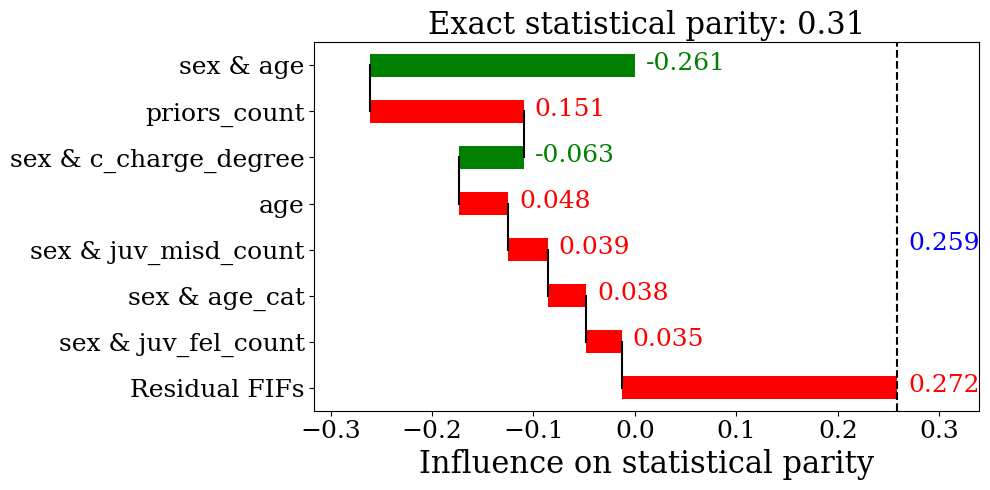

<Figure size 1000x500 with 0 Axes>

In [13]:
plt = draw_plot(
    result, 
    draw_waterfall=True, 
    fontsize=22, 
    labelsize=18, 
    figure_size=(10, 5), 
    title="Exact statistical parity: {}".format(round(value_statistical_parity, 3)), 
    xlim=None,
    x_label="Influence on statistical parity", 
    text_x_pad=0.02, 
    text_y_pad=0.1, 
    result_x_pad=0.02, 
    result_y_location=0.5, 
    delete_zero_weights=False
    )
plt.show()
plt.clf()

### Explaining equalized odds

Next, we explain equalized odds, which belongs to separation group fairness metrics.

$$
\textbf{Equalized odds } = \max_{y \in [0, 1]}(\max_{\mathbf{a}} \Pr[\widehat{Y} = 1 | Y = y, \mathbf{A} = \mathbf{a}] - \min_{\mathbf{a}} \Pr[\widehat{Y} = 1 | Y = y, \mathbf{A} = \mathbf{a}])
$$

Thus, for explaining equalized odds, we additionally provide the true class of samples in the dataset.

In [14]:
value_equalized_odds = []
for y in y_train.unique():
    positive_prediction_probabilities = np.array(
        intersection(selection_rate, y_train[y_train == y], clf.predict(X_train[y_train == y]), prot_attr=prot_attr)) # considering intersectional protected attributes
    value_statistical_parity = positive_prediction_probabilities.max() - positive_prediction_probabilities.min()
    value_equalized_odds.append(value_statistical_parity)

# taking the max
value_equalized_odds = np.max(value_equalized_odds)
print("Equalized odds difference: ", value_equalized_odds)

Equalized odds difference:  0.31580548179170126


In [15]:
results, bias_values = fairxplain_equalized_odds(
                    clf, 
                    X_train, 
                    y_train, # For equalized odds, we need to pass the true labels as well
                    prot_attr=prot_attr, 
                    maxorder=2,
                    spline_intervals=4,
                    seed = 22,
                    verbose=False,
                    return_bias=True)
# Since there are two class labels, results is a list of length 2

We view explaining equalized odds as explaining statistical parity on a sub-dataset based on true class $Y \in \{0, 1\}$. Therefore, we obtain `results` from FairXplainer as a list of two explanation results for two true classes. In the following plot, we demonstrate FIFs corresponding to the maximum exhibited bias for $Y \in \{0, 1\}$. In the waterfall diagram, the prior count and the combined effect of sex with features such as age and juvenile counts are increasing bias, while the joint effect of sex and age decreases bias.

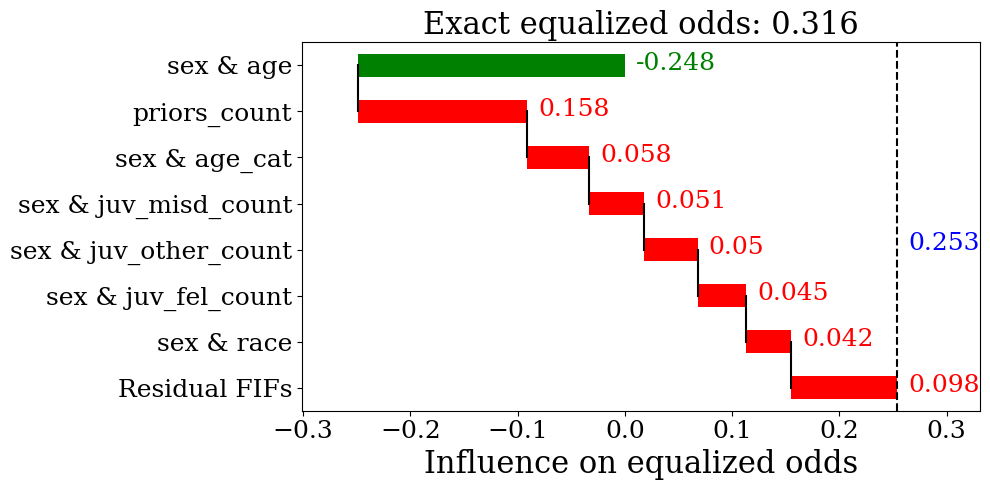

<Figure size 1000x500 with 0 Axes>

In [16]:
index_max_unfairness = np.argmax(bias_values) # we choose the class label with the highest bias for equalized odds
try:
    assert bias_values[index_max_unfairness] == value_equalized_odds
except:
    print("The bias value returned by the function is not equal to the value computed by aif360 metric")
    pass
plt = draw_plot(results[index_max_unfairness], 
                draw_waterfall=True, 
                fontsize=22, 
                labelsize=18, 
                figure_size=(10, 5), 
                title="Exact equalized odds: {}".format(round(value_equalized_odds, 3)), 
                xlim=None,
                x_label="Influence on equalized odds", 
                text_x_pad=0.02, 
                text_y_pad=0.1, 
                result_x_pad=0.02, 
                result_y_location=0.5, 
                delete_zero_weights=False
)
plt.show()
plt.clf()

### Explaining predictive parity

Finally, we explain predictive parity, which belongs to sufficiency group fairness metrics.
$$
\textbf{Predictive parity } = \max_{y \in [0, 1]}(\max_{\mathbf{a}} \Pr[Y = 1 | \widehat{Y} = y, \mathbf{A} = \mathbf{a}] - \min_{\mathbf{a}} \Pr[Y = 1 | \widehat{Y} = y, \mathbf{A} = \mathbf{a}])
$$

Similar to equalized odds, we provide the true class for explaining predictive parity. Methodologically, in predictive parity we treat the true class $Y$ similar to the predicted class $\widehat{Y}$ while explaining statistical parity and equalized odds.


In [17]:
results, bias_values = fairxplain_predictive_parity(
            clf, 
            X_train, 
            y_train, # For predictive parity, we need to pass the true labels as well
            prot_attr=prot_attr, 
            maxorder=2, 
            spline_intervals=4,
            seed = 22,
            verbose=False,
            return_bias=True)

The procedure for explaining predictive parity is similar to equalized odds, except we generate two explanations for $\widehat{Y} \in \{0, 1\}$. Then, we demonstrate explanations corresponding to the maximum exhibiting bias between $\widehat{Y} \in \{0, 1\}$. We find that the predictive parity for COMPAS dataset is low ($0.037$), where positive FIFs (increasing bias) are almost nullified by negative FIFs (decreasing bias). Even in that case, several features such as priors count and sex push towards increasing bias. Thus, a special attention should be paid on features resulting in prediction bias regardless of different group fairness definitions, which we pursue as a future work.

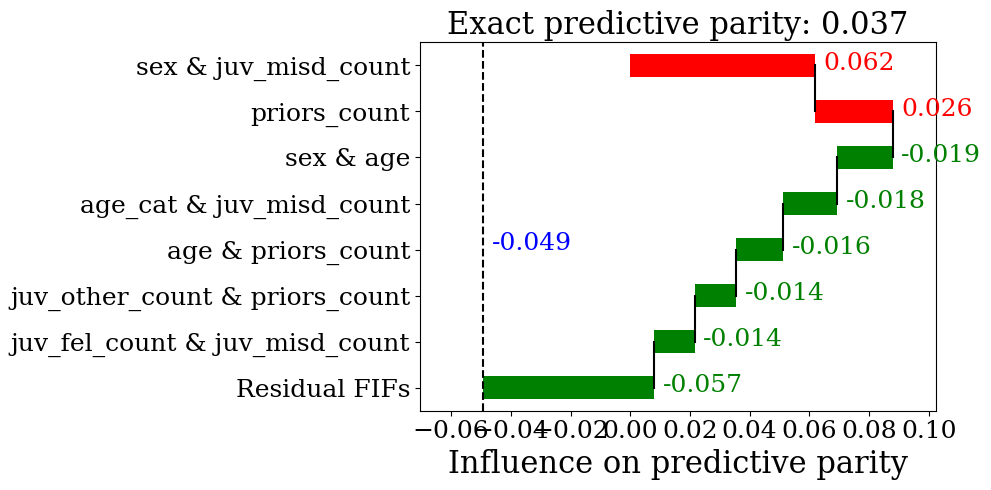

<Figure size 1000x500 with 0 Axes>

In [18]:
index_max_unfairness = np.argmax(bias_values)
plt = draw_plot(results[index_max_unfairness],
                draw_waterfall=True,
                fontsize=22,
                labelsize=18,
                figure_size=(10, 5),
                title="Exact predictive parity: {}".format(round(bias_values[index_max_unfairness], 3)),
                xlim=None,
                x_label="Influence on predictive parity",
                text_x_pad=0.02,
                text_y_pad=0.1,
                result_x_pad=0.02,
                result_y_location=0.5,
                delete_zero_weights=False
)
plt.show()
plt.clf()


**References**:

[1] Bishwamittra Ghosh, Debabrota Basu, and Kuldeep S. Meel. "How Biased are Your Features?": Computing Fairness Influence Functions with Global Sensitivity Analysis. *arXiv preprint arXiv:2206.00667 (2022)*.